**Artificial Inteligence (CS550)**
<br>
Date: **26 January 2020**
<br>

Title: **Seminar 1 - Part B**

Speaker: **Dr. Shota Tsiskaridze**


Bibliography: 
<br>
[1] Jeremy Howard & Sylvain Gugger, Deep Learning for Coders with fastai & PyTorch, O'Reilly Media, Inc., 2020
<br>
[2] Video materials: https://course.fast.ai/videos/?lesson=2
<br>
[3] Jupyter-Notebook: https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb#scrollTo=rkUXFfPYcql5

<h2 align="center">From Model to Production</h2>

<br>
<center><img src="images/S1_State.png" width="1000"  alt="Example" /></center>



In [1]:
!pip install azure-cognitiveservices-search-imagesearch

In [5]:
!pip install -Uqq fastbook


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spyder 4.1.5 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.1.5 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.


In [6]:
import fastbook
fastbook.setup_book()

In [9]:
from fastbook import *
from fastai.vision.widgets import *

- To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. 


- You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [10]:
key = os.environ.get('AZURE_SEARCH_KEY', '79c9916be58745768933d06a8507581e')

- And then restart Jupyter Notebook, and use the above line without editing it.

- Once you've set `key`, you can use `search_images_bing`. 


- This function is provided by the small `utils` class included with the notebooks online. 


- If you're not sure where a function is defined, you can just type it in your notebook to find out:

In [11]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [12]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

- We've successfully downloaded the URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term).


- **Note**: there's no way to be sure exactly what images a search like this will find. 

  The results can change over time. 
  
  We've heard of at least one case of a community member who found some unpleasant pictures of dead bears in their search results. 
  
  You'll receive whatever images are found by the web search engine.
  
  Let's look at one:

In [13]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [14]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

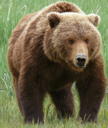

In [15]:
im = Image.open(dest)
im.to_thumb(128,128)

- This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. 


- We'll put each in a separate folder:

In [16]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [17]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [18]:
fns = get_image_files(path)
fns

(#413) [Path('bears/black/00000000.jpg'),Path('bears/black/00000001.jpg'),Path('bears/black/00000002.jpg'),Path('bears/black/00000003.jpg'),Path('bears/black/00000004.jpg'),Path('bears/black/00000005.jpg'),Path('bears/black/00000006.jpg'),Path('bears/black/00000007.jpg'),Path('bears/black/00000008.jpg'),Path('bears/black/00000009.jpg')...]

- Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [19]:
failed = verify_images(fns)
failed

(#8) [Path('bears/black/00000090.jpg'),Path('bears/black/00000145.jpg'),Path('bears/grizzly/00000046.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/teddy/00000039.jpg'),Path('bears/teddy/00000100.jpg'),Path('bears/teddy/00000120.jpg'),Path('bears/teddy/00000138.jpg')]

- To remove all the failed images, you can use `unlink` on each of them. 


- Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. 


- This calls the passed function on each element of the collection:

In [20]:
failed.map(Path.unlink);

In [58]:
??verify_images

<h2 align="center">From Data to DataLoaders</h2>


- `DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. 


- Although it's a very simple class, it's very important in fastai: it provides the data for your model. 


- The key functionality in `DataLoaders` is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

In [22]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

<center><img src="images/S1_DataBlock.png" width="1000"  alt="Example" /></center>

- To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:
  - What kinds of data we are working with
  - How to get the list of items
  - How to label these items
  - How to create the validation set


- So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. 


- For when you don't, fastai has an extremely flexible system called the *data block API*. 


- With this API you can fully customize every stage of the creation of your `DataLoaders`. 




- Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [23]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [27]:
dls = bears.dataloaders(path)

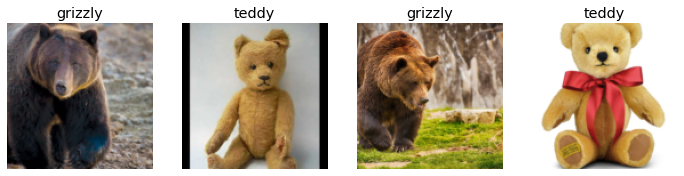

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

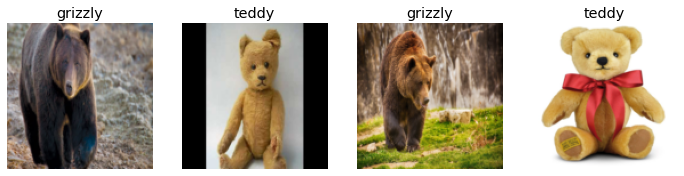

In [29]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

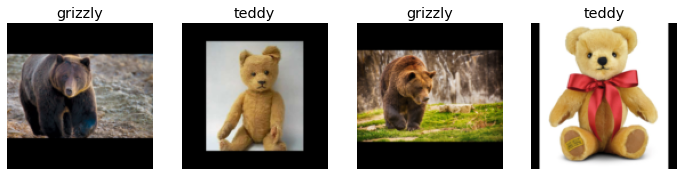

In [30]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [36]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path, num_workers = 0)

In [37]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.309010,0.075419,0.012346,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.129968,0.040069,0.012346,00:15
1,0.079369,0.035783,0.012346,00:14
2,0.065069,0.015059,0.012346,00:14
3,0.049643,0.016141,0.012346,00:15


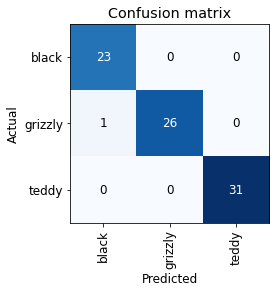

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

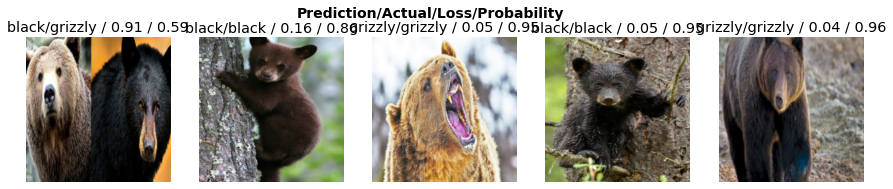

In [39]:
interp.plot_top_losses(5, nrows=1)

- fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:|

In [40]:
cleaner = ImageClassifierCleaner(learn)
cleaner

<h2 align="center">Using the Model for Inference</h2>

- Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. 

  Remember that a model consists of two parts: the **architecture** and the trained **parameters**. 
  
  The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. 
  
  To save both parts, use the `export` method.


- This method even saves the definition of how to create your `DataLoaders`. 

  This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. 
  
  fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.


- When you call `export`, fastai will save a file called "export.pkl":

In [41]:
learn.export()

In [42]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [43]:
learn_inf = load_learner(path/'export.pkl')

In [44]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.1977e-05, 9.9999e-01, 7.2496e-07]))

In [45]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [46]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [47]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [48]:
img = PILImage.create(btn_upload.data[-1])

In [49]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [50]:
pred,pred_idx,probs = learn_inf.predict(img)

In [51]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [52]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [53]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [54]:
btn_upload = widgets.FileUpload()

In [55]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

<h1 align="center">End of Part B</h1>

- For the next Lecture, please read the next chapter in **Russell & Norvig, Artificial Intelligence: A Modern Approach, 2010**:

  **Chapters 3**: Solving Problems by Searching
  
  **Chapter 5**: Adversarial search
  
  **Chapter 10.2-10.5**: Planning
  
  **Chapter 11**: Planning and Acting in the Real World